In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchaudio.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
import math
import librosa
import librosa.display
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
import sklearn
import os
from torchsummary import summary

In [ ]:
Data_inlab=pd.read_csv('InLab_NN.csv')
Data_inlab['ibif_acflow']=Data_inlab['ibif_acflow']/1000
Data_inlab['Ps']=Data_inlab['Ps']*98.0665
Data_inlab

,Unnamed: 0,SubjectID,condition,gender,peak_index,pitch,quality,vowel,Ps_m1,Ps_m2,...,ibif_acflow,ibif_mfdr,ibif_h1h2,ibif_oq,ibif_sq,ibif_naq,ibif_hrf,ibif_f0,acc_f0,Ps_NN
0,0,NF002,normal,F,3,comfortable,modal,a,9.260646,11.601520,...,0.161813,671.233943,5.765352,52.233677,486.342593,0.049962,-0.507651,207.253886,204.876040,7.971257
1,1,NF002,normal,F,4,comfortable,modal,a,7.545824,9.634000,...,0.100727,505.531885,8.815717,42.396313,131.085492,0.049635,-5.002770,249.110320,211.877969,8.648448
2,2,NF002,normal,F,5,comfortable,modal,a,5.038262,6.257666,...,0.083088,284.150763,10.068140,68.421053,58.476980,0.061451,-5.164230,210.157618,208.423697,7.278603
3,3,NF002,normal,F,6,comfortable,modal,a,4.076063,5.134156,...,0.047759,184.575708,12.515432,58.496241,79.597354,0.054762,-8.642713,211.640212,210.119605,6.593817
4,4,NF002,normal,F,7,comfortable,modal,a,3.346026,3.478173,...,0.039989,100.684732,16.270406,73.708207,253.476345,0.084280,-13.457584,212.201592,209.700106,5.090527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15155,212,PM057,uvfp,M,2,high,modal,u,8.803225,8.074281,...,0.078829,94.456016,24.569979,70.068027,193.888889,0.171192,-24.427688,205.128205,229.699678,6.085783
15156,213,PM057,uvfp,M,3,high,modal,u,9.005508,9.440667,...,0.056298,76.805754,17.393843,66.052227,116.908415,0.157634,-17.078416,215.053763,245.180074,6.868375
15157,214,PM057,uvfp,M,4,high,modal,u,7.781924,7.389574,...,0.044268,34.167549,20.203928,95.286195,151.626303,0.271331,-19.963130,209.424084,214.208332,5.379981
15158,215,PM057,uvfp,M,5,high,modal,u,8.958859,9.381394,...,0.060002,77.232859,14.256172,51.177394,89.607813,0.171691,-13.872684,220.994475,229.476744,7.436692


In [ ]:
Data_inlab_normal=Data_inlab[Data_inlab['condition']=='normal']
subjects=np.unique(Data_inlab_normal['SubjectID'])
print(subjects)
ID_Subject=Data_inlab_normal['SubjectID'].to_numpy()
Subject=np.unique(ID_Subject)
Data_inlab_normal= pd.DataFrame(Data_inlab_normal, columns=['ibif_acflow','ibif_mfdr','ibif_oq','ibif_sq', 'ibif_f0','ibif_h1h2', 'level_dB', 'Ps'])
Data_inlab_normal.columns =['ACFL','MFDR','OQ_mean','sQ_mean', 'f0','H1H2', 'spl', 'Ps']

dataset_Clinic=Data_inlab_normal

dataset_Clinic

['NF002' 'NF006' 'NF008' 'NF015' 'NF017' 'NF019' 'NF021' 'NF024' 'NF027'
 'NF028' 'NF029' 'NF030' 'NF032' 'NF035' 'NF039' 'NF040' 'NF041' 'NF044'
 'NM001' 'NM003' 'NM009' 'NM013' 'NM016' 'NM022' 'NM026' 'NM031']


,ACFL,MFDR,OQ_mean,sQ_mean,f0,H1H2,spl,Ps
0,0.161813,671.233943,52.233677,486.342593,207.253886,5.765352,94.121538,1130.163310
1,0.100727,505.531885,42.396313,131.085492,249.110320,8.815717,88.996536,878.937787
2,0.083088,284.150763,68.421053,58.476980,210.157618,10.068140,83.062238,599.918722
3,0.047759,184.575708,58.496241,79.597354,211.640212,12.515432,77.470923,462.209312
4,0.039989,100.684732,73.708207,253.476345,212.201592,16.270406,72.171007,405.306744
...,...,...,...,...,...,...,...,...
8288,0.060065,92.934768,64.297521,92.655784,165.975104,18.627020,74.763840,451.089454
8289,0.053618,95.646861,61.196581,111.761482,171.673820,17.110855,74.532837,459.574568
8290,0.085968,106.846702,40.161290,65.241265,164.271047,21.148496,72.674284,462.620422
8291,0.072425,114.177928,72.203390,298.426760,169.133192,18.756192,73.886476,422.718791


In [ ]:
dataset_Clinic.describe().T

,count,mean,std,min,25%,50%,75%,max
ACFL,8293.0,0.171374,0.192922,0.001077,0.049194,0.109041,0.221522,1.878599
MFDR,8293.0,360.444024,394.375247,2.036439,92.780517,224.085673,482.822537,3165.379937
OQ_mean,8293.0,54.797064,12.153104,4.388715,46.699670,54.844007,62.318841,99.666667
sQ_mean,8293.0,156.729256,88.245790,1.184465,115.305250,142.230156,176.608225,3788.942029
f0,8293.0,238.741917,94.926851,65.789474,170.212766,222.222222,287.769784,628.930818
H1H2,8293.0,13.007991,7.476387,-0.000000,8.029480,12.242365,17.170730,57.482502
spl,8293.0,79.404878,8.410436,46.717462,73.430305,79.647695,85.507213,105.521610
Ps,8293.0,741.661234,355.228875,100.216374,481.407228,680.238322,927.853300,2638.920878


In [ ]:
class MLP(nn.Module):


        def __init__(self, neurons_MLP=128, drop_out=0.2):
            super().__init__()
            # conv block
            self.MLP_1 = nn.Sequential(
            nn.Linear(7,256),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            )
            self.MLP_2 = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            )
            self.MLP_3 = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            )
            self.MLP_4 = nn.Sequential(
            nn.Linear(64,1),
            )



        def forward(self,x):
            x1 = self.MLP_1(x)
            x2 = self.MLP_2(x1)
            x3 = self.MLP_3(x2)

            x4 = self.MLP_4(x3)
            return x4

In [ ]:
def norm(x, train_stats):
  return (x - train_stats['min']) / (train_stats['max']- train_stats['min'] )

def norm_labels(x, labels_train_stats):
  return (x - labels_train_stats['min']) / (labels_train_stats['max']- labels_train_stats['min'] )


In [ ]:
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:
results =pd.DataFrame([], columns=["RMSE", "MAE","MAPE", "R2", 'RMSE_best_fold'], index=subjects)


In [ ]:
def train(subject):

    True_Value_by_subject,   NN_prediction_by_subject=[],[]
    print('')
    print(subject)
    Data_input_by_subject= pd.DataFrame(dataset_Clinic[ID_Subject==subject], columns=['ACFL','MFDR','OQ_mean','sQ_mean', 'f0','H1H2', 'spl'])
    Data_label_by_subject= pd.DataFrame(dataset_Clinic[ID_Subject==subject], columns=['Ps'])

    train_stats = Data_input_by_subject.describe().transpose()
    labels_train_stats = Data_label_by_subject.describe().transpose()
    normed_train_data_Clinic_bysubject = norm(Data_input_by_subject,train_stats ).to_numpy()
    normed_train_labels_Clinic_bysubject = norm_labels(Data_label_by_subject, labels_train_stats).to_numpy()

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if device=='cuda':
        torch.cuda.set_device(1)


    BATCH_SIZE = 8

    sgkf = sklearn.model_selection.KFold(n_splits=5)

    RMSE_Ps, True_Value, NN_prediction =[],[],[]
    MAE_Ps, MAPE_Ps, R2_Ps =[],[],[]
    for k, (train_index, val_index) in enumerate(sgkf.split(normed_train_data_Clinic_bysubject, normed_train_labels_Clinic_bysubject)):

        X_train=normed_train_data_Clinic_bysubject[train_index]
        Y_train= normed_train_labels_Clinic_bysubject[train_index]
        X_train_tensor = torch.tensor(X_train,device=device).float()
        Y_train_tensor = torch.tensor(Y_train,device=device).float()

        X_test=normed_train_data_Clinic_bysubject[val_index]
        Y_test= normed_train_labels_Clinic_bysubject[val_index]
        X_test_tensor = torch.tensor(X_test,device=device).float()
        Y_test_tensor = torch.tensor(Y_test,device=device).float()

        results_loss=[]

        DATASET_SIZE=X_train.shape[0]
        iters = int(DATASET_SIZE / BATCH_SIZE)

        model = MLP().to(device)
        model.apply(reset_weights)
        model.load_state_dict(torch.load(os.path.join('Model_syntethic_6.pt')))
        for param in model.MLP_1.parameters():
            param.requires_grad = False

        model.MLP_4.apply(reset_weights)
        model.MLP_3.apply(reset_weights)
        model.MLP_2.apply(reset_weights)

        loss_func = nn.MSELoss()  # mean square error
        lambda1 = lambda epoch: 0.95 ** epoch
        optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
        dataset=TensorDataset(X_train_tensor,Y_train_tensor)
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

        for epoch in range(100):
            epoch_acc = 0
            epoch_loss = 0
            for id_batch, (x_batch, y_batch) in enumerate(dataloader):
                actual_batch_size=x_batch.shape[0]

                # zero the parameter gradients
                model.train()
                optimizer.zero_grad()

                # forward
                outputs = model(x_batch)


                # calculate loss + backward + optimize
                loss = loss_func(outputs, y_batch)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch +1}: iteration {id_batch +1}/{iters} RMSE: {np.sqrt(epoch_loss):.2f}",end='')
        # append history
        scheduler.step()
        results_loss.append(epoch_loss)

        with torch.no_grad():
            model.eval()
            output_test = model(X_test_tensor)

        test_predictions=output_test[:,0]*(labels_train_stats['max'][0]- labels_train_stats['min'][0] ) + labels_train_stats['min'][0]
        Real_label=Y_test_tensor[:,0]*(labels_train_stats['max'][0]- labels_train_stats['min'][0] ) + labels_train_stats['min'][0]


        RMSE_Clinic = loss_func(Real_label.data.cpu()/98.0665, test_predictions.data.cpu()/98.0665)
        MAE_Clinic=np.mean(np.abs(Real_label.data.cpu().numpy()-test_predictions.data.cpu().numpy())/98.0665)
        MAPE_Clinic=np.mean(np.abs((Real_label.data.cpu().numpy()-test_predictions.data.cpu().numpy())/Real_label.data.cpu().numpy()))*100
        R2_Clinic=sklearn.metrics.r2_score(Real_label.data.cpu().numpy(), test_predictions.data.cpu().numpy())

        RMSE_Ps.append(np.sqrt(RMSE_Clinic.item()))
        MAE_Ps.append(MAE_Clinic)
        MAPE_Ps.append(MAPE_Clinic)
        R2_Ps.append(R2_Clinic)
        print('')
        print('Error',np.sqrt(RMSE_Clinic.item()))
        if k==0:
          True_Value=Real_label
          NN_prediction=test_predictions
        else:
          True_Value=torch.concat([True_Value,Real_label])
          NN_prediction=torch.concat([NN_prediction,test_predictions])


    return True_Value, NN_prediction, RMSE_Ps, MAE_Ps, R2_Ps,MAPE_Ps






NF002
 Epoch 100: iteration 8/8 RMSE: 0.06
Error 0.8624166586595744
 Epoch 100: iteration 8/8 RMSE: 0.06
Error 0.6844631443132881
 Epoch 100: iteration 8/8 RMSE: 0.03
Error 1.0275141353516617
 Epoch 100: iteration 8/8 RMSE: 0.06
Error 0.9801893710100495
 Epoch 100: iteration 8/8 RMSE: 0.07
Error 0.9666059517428349

Ps RMSE: 0.9042378522154818 (  0.12239721360689727) 
Ps MAE: 0.6555085778236389 (  0.10986592620611191) 
Ps R2: 0.9199752819715974 (  0.03029958033414709) 
Ps MAPE: 13.432751595973969 (  1.773295056034627) 
Ps R2: 0.9307678864676887 


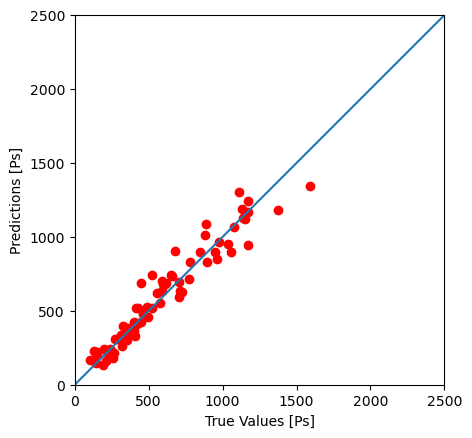

In [ ]:
subject=subjects[0]
Real_Value, Predicted, RMSE_Ps, MAE_Ps, R2_Ps,MAPE_Ps = train(subject)
results.loc[[subject]]=np.mean(RMSE_Ps), np.mean(MAE_Ps), np.mean(MAPE_Ps), np.mean(R2_Ps), np.min(RMSE_Ps)
print('')
print(f"Ps RMSE: {np.mean(RMSE_Ps)} (  {np.std(RMSE_Ps)}) ")
print(f"Ps MAE: {np.mean(MAE_Ps)} (  {np.std(MAE_Ps)}) ")
print(f"Ps R2: {np.mean(R2_Ps)} (  {np.std(R2_Ps)}) ")
print(f"Ps MAPE: {np.mean(MAPE_Ps)} (  {np.std(MAPE_Ps)}) ")
R2=sklearn.metrics.r2_score(Real_Value.cpu().numpy(),Predicted.cpu().numpy())
print(f"Ps R2: {R2} ")
plt.scatter(Real_Value.cpu(), Predicted.cpu(), color= 'r')
plt.xlabel('True Values [Ps]')
plt.ylabel('Predictions [Ps]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.ylim([0,2500])
plt.xlim([0,2500])
_ = plt.plot([-100, 3000], [-100, 3000])